First, let's permit this notebook to access our Google Drive files. So, we can get our dataset in.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#Import important libraries.
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from matplotlib.patches import ConnectionPatch # Connected Patches
import missingno as msno # Missingness visualization.

from statsmodels.formula.api import ols # Regression analysis
from scipy.stats import linregress # Regression analysis.
from empiricaldist import Pmf, Cdf  # Probability mass function & Cumulative distribution function.

In [4]:
# url link to gss dataset from google drive.
url= "/content/gdrive/MyDrive/Surveys/General Social Survey (GSS).hdf5"

# Read and display our dataset
gss = pd.read_hdf(url)
gss.head()

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall
0,1972,26.0,1946.0,1,1,18.0,13537.0,2.0,NaN,0.8893
1,1972,38.0,1934.0,2,1,12.0,18951.0,1.0,NaN,0.4446
2,1972,57.0,1915.0,1,1,12.0,30458.0,1.0,NaN,1.3339
3,1972,61.0,1911.0,2,1,14.0,37226.0,1.0,NaN,0.8893
4,1972,59.0,1913.0,1,1,12.0,30458.0,2.0,NaN,0.8893


***A bit more information and a summary of our survey.***

In [ ]:
gss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62466 entries, 0 to 62465
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     62466 non-null  int64  
 1   age      62281 non-null  float64
 2   cohort   62282 non-null  float64
 3   sex      62466 non-null  int64  
 4   race     62466 non-null  int64  
 5   educ     62304 non-null  float64
 6   realinc  55499 non-null  float64
 7   gunlaw   40550 non-null  float64
 8   grass    36222 non-null  float64
 9   wtssall  62466 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 5.2 MB


As we can observe, We've ***62466 entries***, One row per each response on the ***General Social Survey*** (GSS).
<br> Seemingly, there're alot of <font color="red"> missingness in ***realic, gunlaw***  and ***grass*** columns</font>.

## ***Data cleaning.***
      As the old says "garbage in garbage out".
***Re-record values in `sex, race, gunlaw and grass columns` for better consistencies.***

In [5]:
sex_map = {2:"Female", 1:"Male"}
race_map = {1: "white", 2: "Black", 3: "Other"}
gunlaw_map = {1: "Yes", 2: "No"}
grass_map = {1: "Should", 2: "Should not"}

mapping= [sex_map, race_map, gunlaw_map, grass_map]
columns= ["sex", "race", "gunlaw", "grass"]

for col, map in zip(columns, mapping):
  gss[col].replace(map, inplace= True)

### ***Dealing with misssingness.***
As we've mentioned in summary above, we'have alot of missingness.

In [ ]:
#This function takes a dataframe and returns the count and percetage of missingness per column.

def get_misssingness(dataframe):
  # Get the missingess count.
  total_missingness = dataframe.isna().sum().sort_values(ascending= False)
  #Exclude columns containing no missingness.
  #total_missingness = total_missingness[total_missingness.values !=0]

  #Get the percentage of missingess per column.
  percentage= np.round(total_missingness* 100/ len(dataframe), 2)
  per = []
  [per.append('{:.1f} %'.format(p)) for p in percentage]
  df = pd.DataFrame({"Missing count": total_missingness, 
                     "Missing percentage": per })
  #df.assign(Percentage = percentage)
  return df

In [ ]:
get_misssingness(gss)

,Missing count,Missing percentage
grass,26244,42.0 %
gunlaw,21916,35.1 %
realinc,6967,11.2 %
age,185,0.3 %
cohort,184,0.3 %
educ,162,0.3 %
year,0,0.0 %
sex,0,0.0 %
race,0,0.0 %
wtssall,0,0.0 %


For better intution, Let's convert this table into a nicer looking chart and visualize it.

In [6]:
# Set a global style for our graphs.
sns.set(font_scale= 1.5, rc={"figure.figsize":(10, 6)})
sns.set_style({'axes.facecolor':'white'})

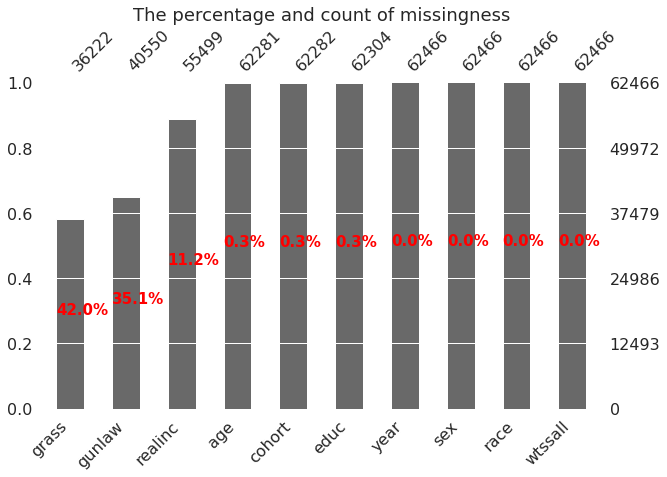

In [ ]:
ax= msno.bar(gss, figsize=(10,6), sort="ascending")
plt.title("The percentage and count of missingness")
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 - (100 * p.get_height()))
        x = p.get_x() 
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 15, weight="bold", color="red")

    On the y-axis: The percentage of remain values per column.
    The count of remain values are recorded upper the graph.
    The percentage of misisngness is recorded in red.
Now, Let's find out more about missingness: ***patterns and reasons***.

In [ ]:
missingness = gss[gss.isna().any(axis= 1)].copy(deep= True) # Extract records containing NANs.

# Exclude corresponding columns ["year", "sex", "race", "wtssall"], as containing no missingness.
missingness.drop(["year", "sex", "race", "wtssall"], axis= 1, inplace= True)
#cols = gss[gss.columns[~ gss.isnull().any()]]
#missingness.drop(cols.columns, axis= 1, inplace= True)


# sort values by gunlaw column to get a better intution.
missingness= missingness.sort_values(by= "gunlaw")

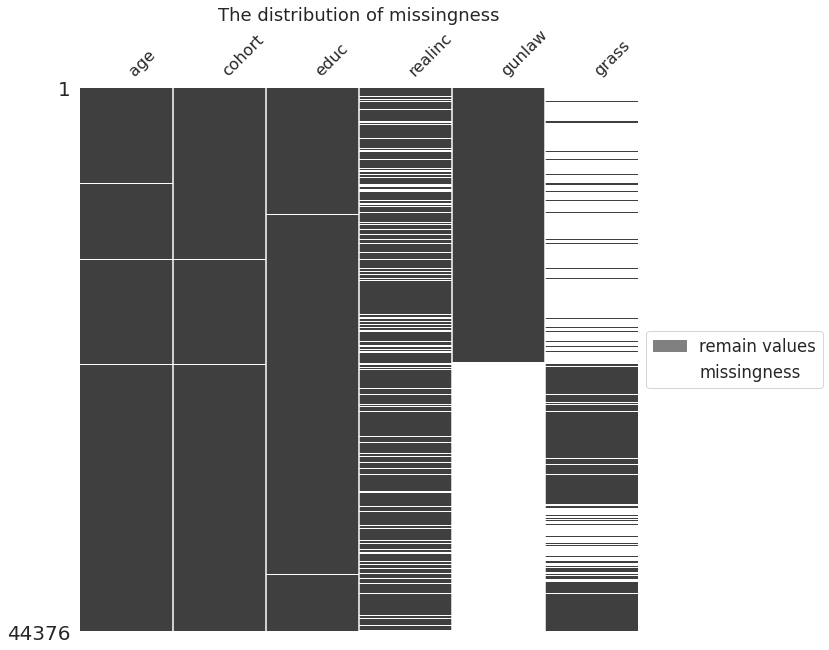

In [ ]:
# Now visualize missingness.
msno.matrix(missingness, figsize=(10,10), sparkline= False)

# Identify patches for better eye_view.
gray_patch, white_patch = mpatches.Patch(color='gray', label='remain values'), mpatches.Patch(color='white', label='missingness')

# Set a legend
plt.legend(handles=[gray_patch, white_patch], loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("The distribution of missingness");

We can describe missingness in GSS as <font color="blue">***missing-not-at-random***</font>, as there's a heigh-relationship between missingness and remaining values.
<br> There's a <font color="red">***strong negative correlation*** </font> between missingness in ***`gunlaw and grass columns`***
<br> And we can notice that there'are a <font color="red"> ***heigh-relation***</font> between missingness in ***`age and cohort columns`***.

Another way to think about it.


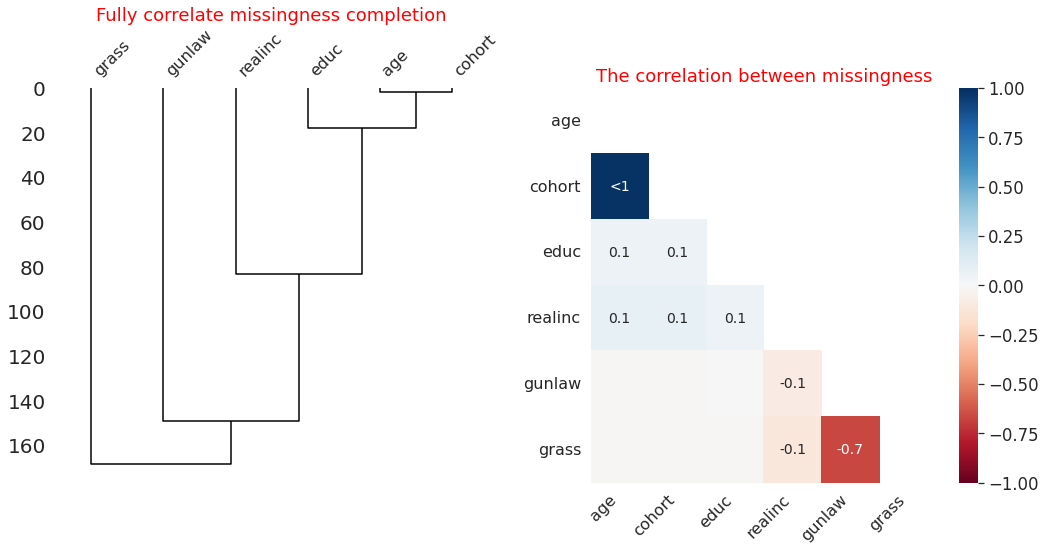

In [ ]:
fig=plt.figure(figsize=(15, 8))

ax1= fig.add_subplot(1,2, 1)

msno.dendrogram(missingness, ax=ax1)
ax1.set_title("Fully correlate missingness completion", color="red");

ax2= fig.add_subplot(1,2, 2)
msno.heatmap(missingness, ax= ax2)
ax2.set_title("The correlation between missingness", color="red");

plt.tight_layout()

Again from this dendogram and heatmap, we can observe:
<br> There is a ***heigh-correlation*** between missingness in ***`age and cohort columns`***and some missied samples in ***`edu and realinc and grass`*** too.
<br> And strog negative correlation between ***`gunlaw and grass columns`***.
<br>This heatmap confirms everything, we have elicited from ***matrix and dendogram***.

<br> From the ***CUMULATIVE CODEBOOK*** of our GSS. [link](https://gss.norc.org/documents/codebook/gss_codebook.pdf), we'll replace NANs in***` gunlaw and grass columns `***with their origin values, "***Don't know***". Which refers to respondents who refused to answer those questions.

In [7]:
for i in ["gunlaw", "grass"]:
  gss[i].replace(np.nan, "Don't know", inplace= True)

Missingness in `age, cohort and educ columns` will be dropped, as they are the same samples and represent 0.3% of our dataset.

In [8]:
# Exclude records with missingness in age, cohort, educ, realinc columns.
gss= gss[- gss["age"].isna()]
# To clarify our idea, check the count of missingness in each column after excluding nans from age column.
gss.isna().sum()

year          0
age           0
cohort        1
sex           0
race          0
educ        151
realinc    6854
gunlaw        0
grass         0
wtssall       0
dtype: int64

#### ***Missingness imputation.***
We're going to impute the remain missingness in ***cohort, educ and realinc columns*** 

***KNN imputation technique.***
<br> It uses the ***K-Nearest Neighbor algorithm*** for predicting the missing values, finding the most similar data points using all the non-missing features for a data point and calculates the average of these similar points to fill the missing feature. Here, K specifies the number of similar or nearest points to consider.
But first let's get our dataset ready.

In [9]:
newdata= pd.get_dummies(gss, columns=["sex", "race", "gunlaw", "grass"])

In [10]:
# Impute missingness with KNN.
from sklearn.impute import KNNImputer
# Copy newdata to data_knn_imputed.
data_knn_imputed = newdata.copy(deep=True)

# Initialize KNN with neighbors equal to 10.
knn_imputer = KNNImputer(n_neighbors= 10 )
# Impute using fit_tranform on data_knn_imputed.
data_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(data_knn_imputed)

Now, re-write values in "cohort", "educ", "realinc" columns, after imputation.

In [11]:
gss[["cohort", "educ", "realinc"]]= data_knn_imputed[["cohort", "educ", "realinc"]]

Check our modifications.

In [ ]:
gss.isna().sum()

year       0
age        0
cohort     0
sex        0
race       0
educ       0
realinc    0
gunlaw     0
grass      0
wtssall    0
dtype: int64

Now, we have no missingness, let's look at the new form of our dataset.

In [ ]:
gss.head()

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall
0,1972,26.0,1946.0,Male,white,18.0,13537.0,No,Don't know,0.8893
1,1972,38.0,1934.0,Female,white,12.0,18951.0,Yes,Don't know,0.4446
2,1972,57.0,1915.0,Male,white,12.0,30458.0,Yes,Don't know,1.3339
3,1972,61.0,1911.0,Female,white,14.0,37226.0,Yes,Don't know,0.8893
4,1972,59.0,1913.0,Male,white,12.0,30458.0,No,Don't know,0.8893


### ***Datatype constrains.***
We've to make sure that data's in correct datatype. Luckily, Python has specific data type objects for various data types. This makes it much easier to manipulate these various data types in Python.

As such, before preparing to analyze and extract insights from our data, we need to make sure our variables have the correct data types, other wise we risk compromising our analysis.

In [ ]:
gss.dtypes

year         int64
age        float64
cohort     float64
sex         object
race        object
educ       float64
realinc    float64
gunlaw      object
grass       object
wtssall    float64
dtype: object

In [12]:
cat =["sex", "race", "gunlaw", "grass"]
integer = ["educ", "age", "year", "cohort"]

#For size reasons, we prefered to convert year and cohort columns to integer, rather than float or datetime.
for cat_column in cat:
  gss[cat_column]= gss[cat_column].astype("category")
for int_column in integer:
  gss[int_column]= gss[int_column].astype("int") 

### ***Cross field validation.***
    Make sure data stored in age column is valid.
`year column` contains the year of interview with respondent, and `cohort column` conatains the year in which the respondent was born.
So, we can say that ***respondent age is considered the output of the Subtraction between year and cohor*** to make sure that data stored in `age column` is valid.

In [ ]:
#Create a new column '_Age' to cross validat data in age column.
gss["_Age"]= gss["year"]- gss["cohort"]
gss.head()

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall,_Age
0,1972,26,1946,Male,white,18,13537.0,No,Don't know,0.8893,26
1,1972,38,1934,Female,white,12,18951.0,Yes,Don't know,0.4446,38
2,1972,57,1915,Male,white,12,30458.0,Yes,Don't know,1.3339,57
3,1972,61,1911,Female,white,14,37226.0,Yes,Don't know,0.8893,61
4,1972,59,1913,Male,white,12,30458.0,No,Don't know,0.8893,59


Now select rows with inconsistencies between age column and _Age that we've just created.

In [ ]:
#Select rows where '_Age' column we've just created does not equal to data stored breviously in age column.  
gss[gss["age"] != gss["_Age"]]

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall,_Age


Well, no records with inconsistencies in age column, which means that data stored in age column is valid.
<br> Now, we're goning to drop _Age column, we have just created.

In [ ]:
# Now drop _Age column
gss.drop("_Age", axis= 1, inplace=True)

## ***Check for duplicates.***

In [ ]:
duplicates= gss.duplicated(subset= gss.columns)
#per= len(gss[duplicates]) / len(gss)
per= round(gss[duplicates].shape[0] * 100 / gss.shape[0], 2)
print("Percentage of duplicates ", per )
gss[duplicates].sort_values(by= "year")

Percentage of duplicates  40.75


,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall
111,1972,47,1925,Female,white,12,43994.0,No,Don't know,1.333900
1278,1972,50,1922,Male,white,14,24366.0,No,Don't know,0.889300
1280,1972,63,1909,Female,white,11,24366.0,Yes,Don't know,0.889300
1281,1972,31,1941,Male,white,12,37226.0,No,Don't know,0.889300
1282,1972,45,1927,Male,white,9,8122.0,No,Don't know,1.333900
...,...,...,...,...,...,...,...,...,...,...
61082,2016,50,1966,Male,white,12,21060.0,No,Should not,1.435490
61080,2016,34,1982,Male,white,10,12870.0,Yes,Should,0.956994
61078,2016,51,1965,Male,white,11,17550.0,Yes,Should,0.478497
61035,2016,51,1965,Female,white,10,38610.0,No,Should not,1.435490


About 40% percentage of our dataset is completely duplicated
<br> complete duplicates can be diagnosed when we have the same exact information repeated across multiple rows.
<br> ***But 40% is considered as a large portion of our dataset, is it true to drop duplicates in this sitution ?!***
<br> Well, we wolked throught our project twice, once without dropping duplicates and for the seconded time we did drop duplicates, and we found out that it does not make any differencies in the analysis results and insights we've extracted from our survey, ***which leads us to think about it to be more likely a data entry error than an actual other sample.***



In [13]:
gss.drop_duplicates(inplace= True)

## ***Statistical summary***.

In [ ]:
round(gss.describe(), 2)

,year,age,cohort,educ,realinc,wtssall
count,36903.00,36903.00,36903.00,36903.00,36903.00,36903.00
mean,1994.02,45.24,1948.78,12.85,33273.28,1.11
std,12.90,17.23,20.81,3.14,29118.05,0.50
min,1972.00,18.00,1883.00,0.00,234.00,0.41
25%,1984.00,31.00,1935.00,12.00,13594.00,0.89
50%,1994.00,43.00,1951.00,12.00,25582.50,1.02
75%,2006.00,58.00,1963.00,15.00,42020.00,1.29
max,2016.00,89.00,1998.00,20.00,162607.00,8.74


The GSS has  been conducted since ***1972 to 2016***. "from `year column`"
<br> The ***youngest and oldes*** in the survey is ***18 and 89*** years old. 25% of respondent less than 30 years old.
<br> About 350 respondents recorded as 18 years, and 253 respondents recorded as 89 years old.
<br>***`cohort column`***, ***which represents in which year the respondent was born*** takes values from 1883 to 1998 and they belong to the oldest and youngest respondents.
<br> Two respondents were born in 1883, and over 200 were born in 1988
<br> Seemingly, we've many ***levels of study***, Because the ***`edu column`*** takes values from ***0 to 20***, which means we have samles got ***None***, ***primary education level***, some samples went to ***hight scool***, some got a ***bachelor degree***, athers  have ***master's degree*** and ***advanced studies***.

In [ ]:
gss.describe(include=["category"])

,sex,race,gunlaw,grass
count,36903,36903,36903,36903
unique,2,3,3,3
top,Female,white,Yes,Don't know
freq,20172,29736,18274,15519


There're more female, and more respondents recorded themselves as white, most responedents prefer to obtain a police permit befor getting a gun, and most of them refused to answer the question about .... in our survey.

For better intution, and better eye view, let's visualize it.
We could have visualized the table into a nicer looking chart at one step, but it's much better to worke with it one-by-one.

In [ ]:
cols= ["sex", "race", "gunlaw", "grass"]
"""
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.suptitle('Title', fontsize=15)
axes = axes.ravel()
for i, col in enumerate(cols):
    fig.sca(axes[i])   
    val_count = gss[col].value_counts()
    plt.pie(x=val_count.values, labels=val_count.index,
            autopct='%0.2f%%', radius=1.2, 
            textprops={'fontsize':14});
    plt.title(col, fontsize=12, weight='bold', color='brown');
"""

## ***Exploratory data analysis (EDA).***

In [ ]:
def display_percentage(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x, y = p.get_x(), p.get_height()
        ax.annotate(percentage, (x, y), size = 14, weight="bold")

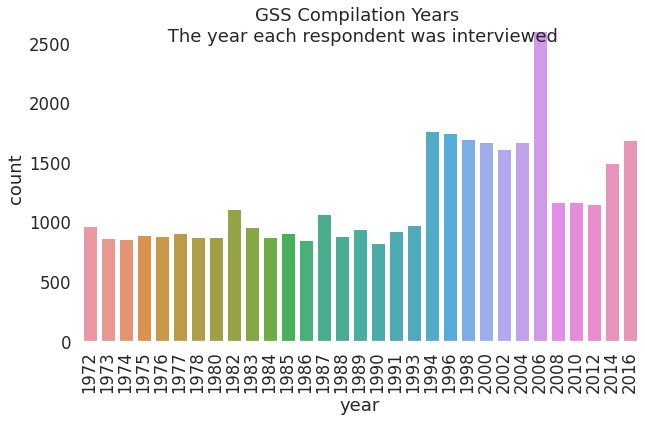

In [ ]:
#ax= sns.countplot(data= gss, x="year")
#display_percentage(ax, gss.year)
sns.countplot(data= gss, x="year")
plt.title("GSS Compilation Years \n The year each respondent was interviewed", y= 0.9)
plt.xticks(rotation=90);

Another way to think about it, is with ***probability mass function*** or pmf. 

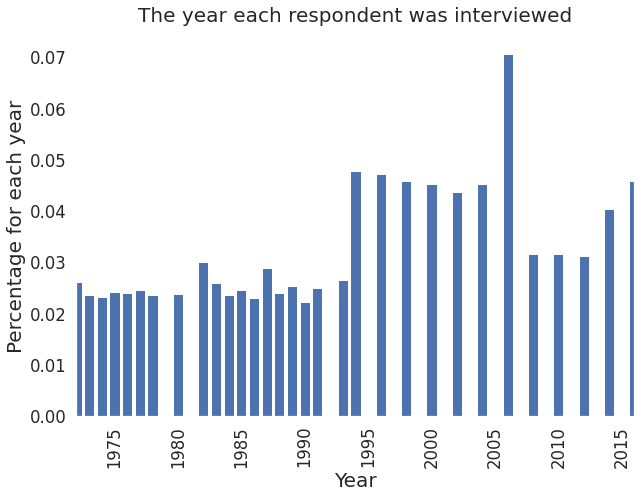

In [14]:
pmf_year = Pmf.from_seq(gss["year"], normalize=True)
plt.figure(figsize=(10,7))
pmf_year.bar()
plt.title("The year each respondent was interviewed", y=1.02, fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.xlim([1972, 2016])
plt.ylabel("Percentage for each year", fontsize=20)
plt.xticks(rotation=90)
plt.show()

Seemingly, 7% of interviews with respondants have been taken place in 2006.

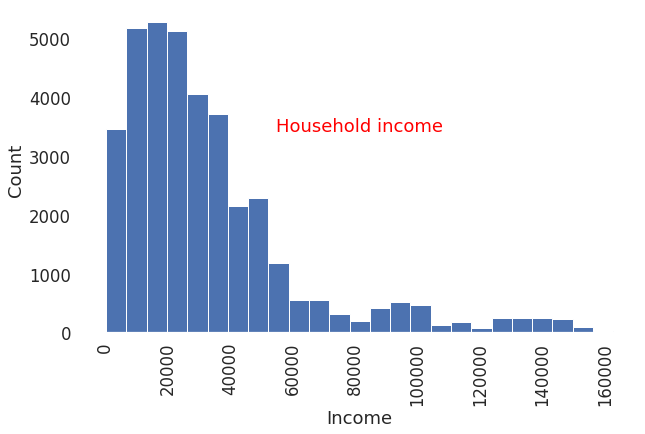

In [ ]:
plt.hist(gss["realinc"], bins=25)
plt.title("Household income", y=0.6, color="red")
plt.xlabel("Income")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

***Right-skewed distribution*** (Positivly-skewed), which means we have ***little respondant with high income***.

But for better intution, let's visualize houshold income using ***comulative distribution function*** or Cdf. 

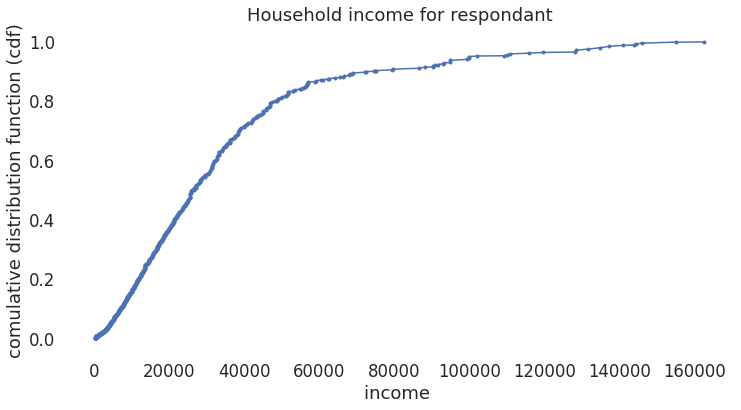

In [ ]:
income=Cdf.from_seq(gss["realinc"], normalize=True)

income.plot(marker='.')
plt.title("Household income for respondant")
plt.xlabel("income ")
plt.ylabel("comulative distribution function (cdf)")
plt.show()

Seemingly, about 85% of respondants' household income less than 60000.
<br> Now, Let's find out how househould income is changed over time.

In [ ]:
year_income= round(pd.DataFrame(gss.groupby(by="year").realinc.mean()), 2)
year_income.head(7)

,realinc
year,
1972,30031.92
1973,33179.25
1974,33372.50
1975,30737.97
1976,30056.21
1977,33490.79
1978,32037.31


Let's convert this table into a nicer looking chart, For better eye-view.

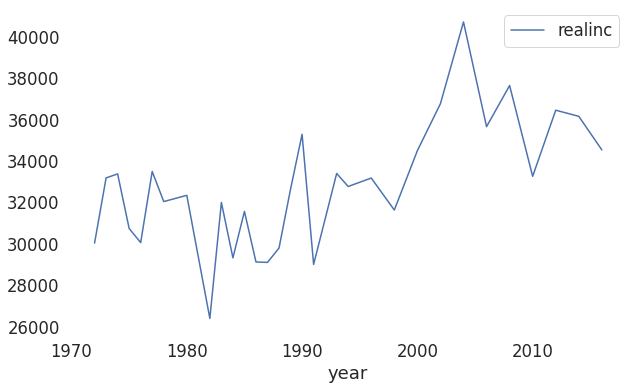

In [ ]:
year_income.plot();

Seemingly, it goes up and down randomly!
<br> We will find out why letter. But let's visualize it on stack with year."`dual axis`" 

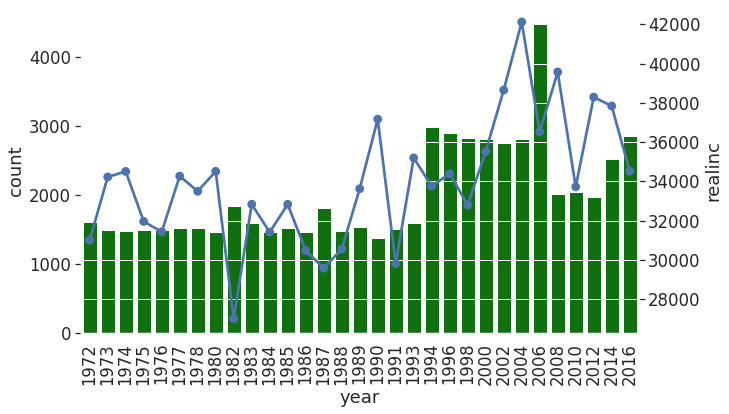

In [ ]:
fig = plt.figure()
ax1 = sns.countplot(data= gss, x='year', color="green")
plt.xticks(rotation=90)
ax2 = ax1.twinx()
sns.pointplot(data= gss, x= "year", y= "realinc", estimator= np.mean, join= True, ci=None);

Actually i hate dual-axis graphs, but it's import form my to visualized it to illustrate an idea, which is why we have got random average over time?! and this graph shows that it does not depend on how many respondents recorded in a year.

In [15]:
def display_pie(dataframe, column, title= None):
  count= dataframe[column].value_counts()
  plt.pie(count, autopct= "%1.f%%",
          labels=count.index,
          shadow=True, textprops={"fontsize":20, "style":"italic"},
          wedgeprops=dict(width=0.8, edgecolor='w'))
  plt.title(title, color="red")

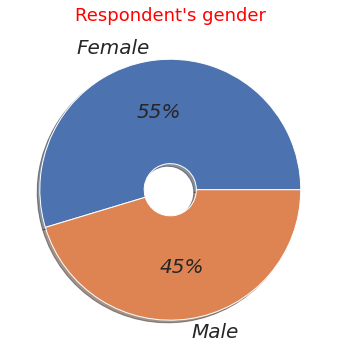

In [ ]:
display_pie(dataframe= gss, column= "sex", title="Respondent's gender")

In [ ]:
gender = gss["sex"].value_counts()
male_race = gss[gss["sex"]== "Male"].race.value_counts()
female_race = gss[gss["sex"]== "Female"].race.value_counts()

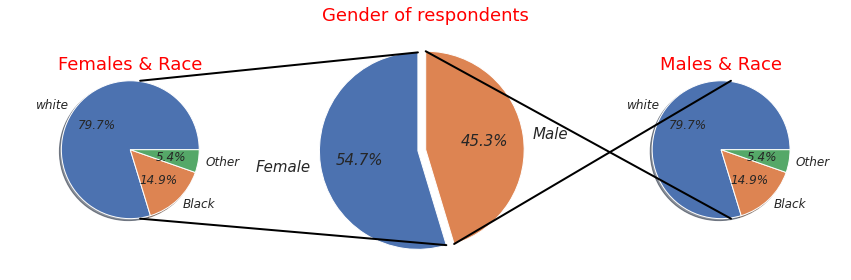

In [ ]:
fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

ax1.pie(gender, labels = gender.index, autopct='%1.1f%%', startangle= 90, 
        explode = [0.08, 0], textprops={"fontsize":15, "style":"italic"})
ax1.set_title("Gender of respondents", color="red")

for ax, title in zip([ax2, ax3], ['Males & Race', 'Females & Race']):
  ax.pie(female_race, labels= male_race.index, autopct='%1.1f%%', radius=0.7, 
        textprops={"fontsize":12, "style":"italic"}, shadow=True)
  ax.set_title(title, color="red", y=0.8)

for i, a in zip([1, 0], [ax2, ax3]):
  theta1, theta2, center, r = ax1.patches[i].theta1, ax1.patches[i].theta2, ax1.patches[i].center, ax1.patches[i].r

  # draw top connecting line
  for (theta, angel) in zip([theta1, theta2], [0.7, -0.7]):
      x, y= r * np.cos(np.pi / 180 * theta) + center[0], np.sin(np.pi / 180 * theta) + center[1]
      con = ConnectionPatch(xyA=(0.1, angel), xyB=(x, y), coordsA="data", coordsB="data", arrowstyle= "-", 
                          axesA=a, axesB=ax1, linewidth=2, color=[0, 0, 0])
      ax2.add_artist(con)

In [ ]:
male, female = gss['sex'] == "Male", gss["sex"] == "Female"
age, income = gss['age'], gss["realinc"]

male_age, female_age = age[male], age[~male]

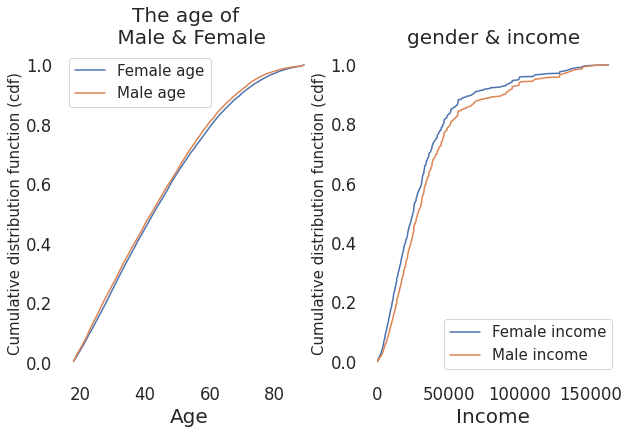

In [ ]:
plt.subplot(1, 2, 1)
Cdf.from_seq(female_age, normalize=True).plot(label="Female age")
Cdf.from_seq(male_age, normalize=True).plot(label="Male age ")

plt.legend(fontsize=15)
plt.title("The age of \n Male & Female", fontsize=20)
plt.xlabel("Age", fontsize=20)
plt.ylabel("Cumulative distribution function (cdf)", fontsize= 15)

plt.subplot(1, 2, 2)
Cdf.from_seq(income[female], normalize=True).plot(label='Female income')
Cdf.from_seq(income[male], normalize=True).plot(label='Male income')

plt.title("gender & income", fontsize=20)
plt.xlabel("Income", fontsize=20)
plt.ylabel("Cumulative distribution function (cdf)", fontsize= 15)
plt.legend(fontsize=15)

plt.show()

As we can observe,
    
***In the middle graph***, the orange line (which refer to male age) to ***the left*** of ***the blue line***(which refers to femal age) across the distribution. which shows that ***men are younger than womman*** at every percentile. 
      Or, another way to think of it: for every age, ***the fraction of men below that age is more than the fraction of women below that age***. But not by very much.

In the right graph, ***men have more income than woman***. Or for every income ***the fraction of men below that income is more than the fraction of women below that incom***. 

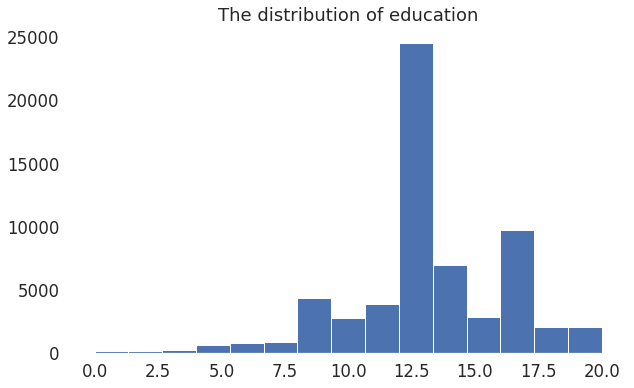

In [ ]:
plt.hist(gss["educ"], bins=15)
plt.title("The distribution of education");

***Left-skewd distribution***, which means we have more respondents with lower level education than heigher-levels.
<br> A deep dive may be informative. So, let's find out more about education column.


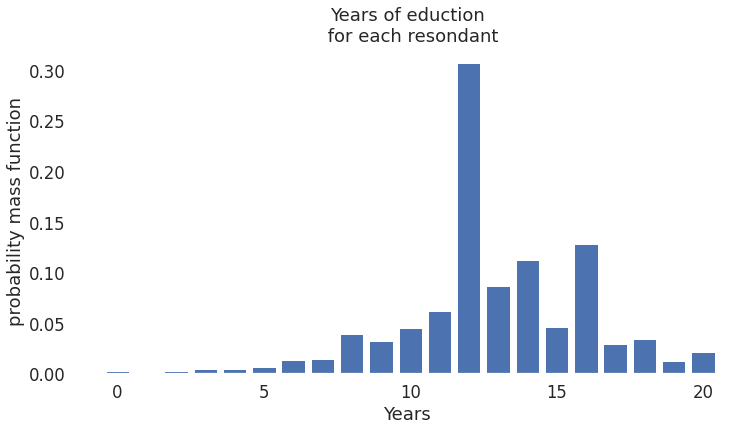

In [ ]:
eductation = Pmf.from_seq(gss["educ"], normalize=True)
eductation.bar(label="education")
plt.title("Years of eduction \n for each resondant")
plt.xlabel("Years ")
plt.ylabel("probability mass function")
plt.show()

Respondents with ***12 years of eduction*** is a little bit more than 30%, which is the most comman in our survey.
<br> There're also peaks at ***14*** and ***16*** which corresond to ***two or four years of colleage***.

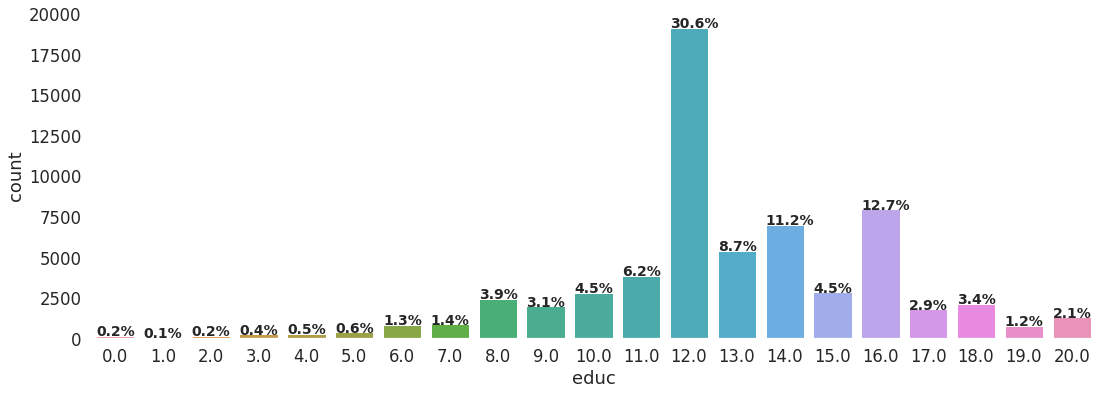

In [ ]:
plt.figure(figsize=(18, 6))
ax= sns.countplot(data= gss, x="educ")
display_percentage(ax, gss["educ"]);

Let's get closer, and look at the relationship between income and education.

In [ ]:
realin_educ= round(pd.DataFrame(gss.groupby(by="educ").realinc.mean()))
realin_educ.head(7)

,realinc
educ,
0,15362.0
1,14282.0
2,24478.0
3,12686.0
4,13336.0
5,14195.0
6,13818.0


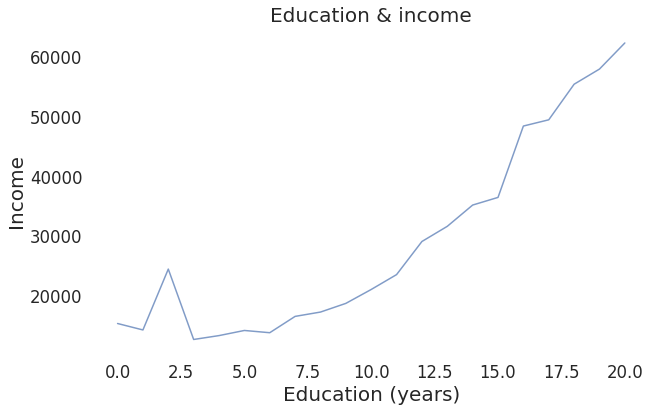

In [ ]:
# Plot mean income as a line plot
plt.clf()
plt.plot(realin_educ, '-', alpha=0.7)

# Label the axes
plt.title("Education & income", fontsize=20)
plt.xlabel('Education (years)', fontsize=20)
plt.ylabel("Income" , fontsize=20)
plt.show()

##### As we can observe, the more years in education the more increasing in houseold income.

In [ ]:
relation = gss.dropna(subset=["educ", "realinc"])
rel = linregress(x=relation["educ"], y=relation["realinc"])
print(rel)

LinregressResult(slope=3492.8297102528086, intercept=-11607.545304673695, rvalue=0.37697529427917553, pvalue=0.0, stderr=44.67465057433202)


let's try it with statsmodesl.

In [17]:
rel= ols("realinc ~ educ", data= gss).fit()
rel.params

Intercept   -11607.545305
educ          3492.829710
dtype: float64

It's expected that househould income will increased by 3586.5 if education level is increased by one.

##### Let's begin comparing incomes for different levels of education and household incomes. In the U.S, 12 years of education usually means the respondent has completed high school (secondary education). A respondent with 14 years of education has probably completed an associate degree (two years of college); someone with 16 years has probably completed a bachelor's degree (four years of college), someone with more than 16 years has probably joined advanced studies.

In [ ]:
# advanced studies
ad_studies =  gss['educ'] >16

# Bachelor's degree
bachelor = (gss['educ'] >= 14) & (gss['educ'] <= 16)

#associate degree (two years of college)
associate = (gss['educ'] < 14) & (gss['educ'] > 12)

# High school (12 or fewer years of education)
high = (gss['educ'] <=12)

income = gss['realinc']

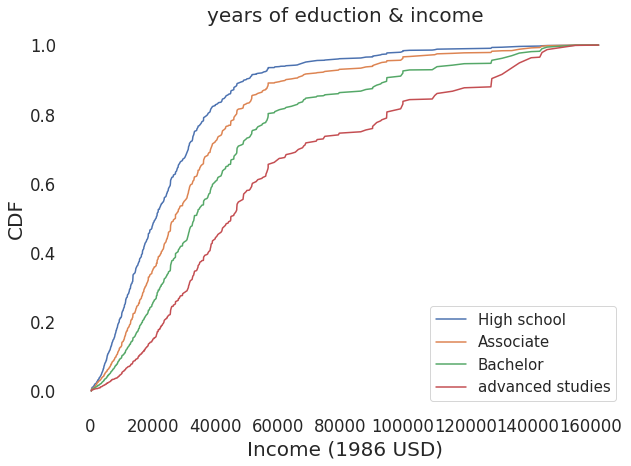

In [ ]:
# Plot the CDFs
plt.figure(figsize=(10,7))
Cdf.from_seq(income[high], normalize=True).plot(label='High school')
Cdf.from_seq(income[associate], normalize=True).plot(label='Associate')
Cdf.from_seq(income[bachelor], normalize=True).plot(label='Bachelor')
Cdf.from_seq(income[ad_studies], normalize=True).plot(label='advanced studies')

# Label the axes
plt.title("years of eduction & income", fontsize=20)
plt.xlabel('Income (1986 USD)', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.legend(fontsize=15)
plt.show()

##### Again the more years in eduction the higher income is, As we can see blue line is leftmost and red line is in rightmost, which means that in every income, the fraction of respondent's income with less years in education has less than fraction of respondent's income with more years in education.


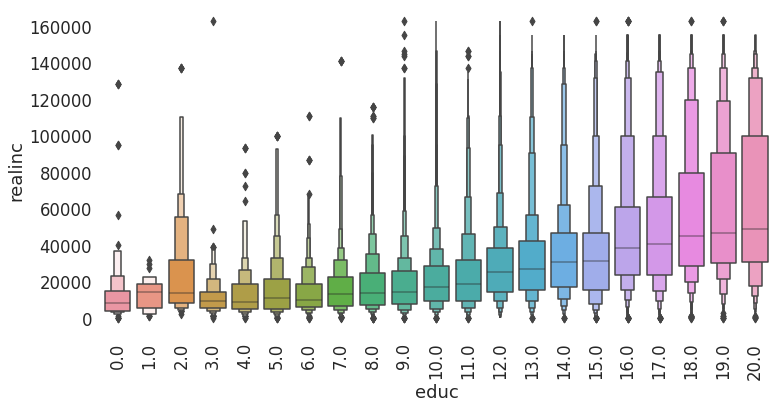

In [ ]:
sns.boxenplot(data= gss, x= "educ", y= "realinc")
plt.xticks(rotation=90);

let's look at household income and compare the distribution before and after 1995. 
<br> I've choosed 1995 because it's roughly the midpoint of the survey.

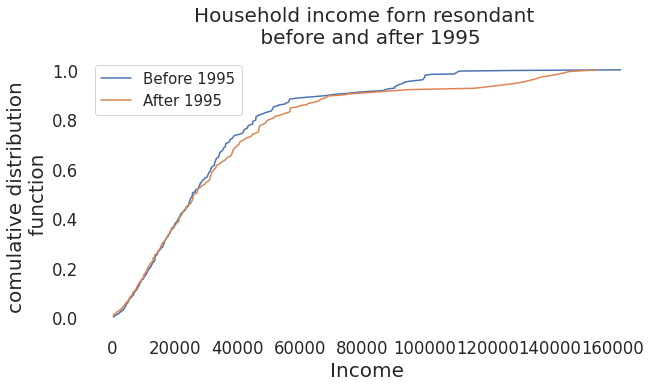

In [ ]:
income = gss['realinc']
pre95 = gss['year'] < 1995

plt.figure(figsize=(10,5))
Cdf.from_seq(income[pre95], normalize=True).plot(label='Before 1995')
Cdf.from_seq(income[~pre95], normalize=True).plot(label='After 1995')
plt.legend(fontsize=15)

plt.title("Household income forn resondant \n before and after 1995", y=1.03, fontsize=20)
plt.xlabel("Income", fontsize=20)
plt.ylabel("comulative distribution \n function ", fontsize=20)
plt.show()

Below $30,000 the CDFs are almost identical; above that, we can see that the orange distribution is shifted to the right. In other words, the fraction of people with high incomes is about the same, but the income of high earners has increased. 

Race, The question associated: 
    
    "what race do you consider yourself?"

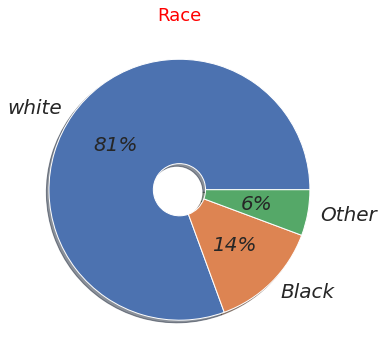

In [ ]:
display_pie(dataframe= gss, column= "race", title= "Race")

As we can see:
<br> ***80%*** of respondents considered themselves as from ***white race***, <br> ***14% as they'are from black race***.
<br> ***6% preferred to consider themselves as not white nor black***, or may they not american origin.

In [ ]:
white, black, other = (gss["race"] ==1), (gss["race"] ==2), (gss["race"] ==3)

income = gss['realinc']

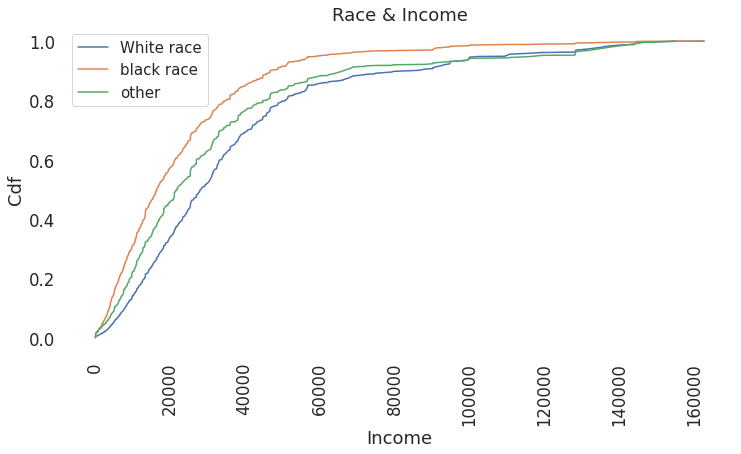

In [ ]:
Cdf.from_seq(income[white], normalize=True).plot(label="White race")
Cdf.from_seq(income[black], normalize=True).plot(label="black race")
Cdf.from_seq(income[other], normalize=True).plot(label="other")

plt.title("Race & Income")
plt.xticks(rotation= 90)
plt.xlabel("Income")
plt.ylabel("Cdf")
plt.legend(fontsize=15)
plt.show()


Do we've relation between Gender and race of the respondents ?

In [ ]:
def Inform(data_frame, groupby, column, num=2):
  dataframe= pd.DataFrame(data_frame.groupby(by= groupby)[column].value_counts(normalize=True) * 100)
  round(dataframe, num)
  emp=[]
  for i in dataframe[column]:
     emp.append('{:.1f}%'.format(i))
  dataframe[column]= emp   
  return dataframe.unstack()

In [ ]:
race_gender= Inform(data_frame= gss, groupby="sex", column="race")
race_gender

race             
race    Black Other  white
sex                       
Female  14.7%  5.6%  79.7%
Male    12.5%  6.2%  81.3%

For better eye view, Let's convert this table into a nicer looking charts

In [18]:
def display_percentage_with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width()
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y+2), ha="right", size=15, weight= "bold")
    plt.show()

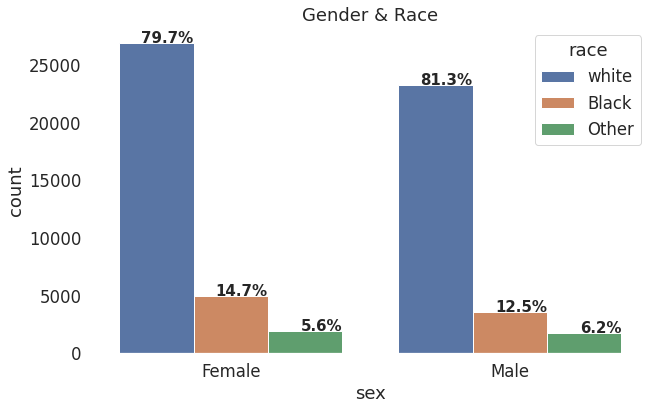

In [ ]:
ax= sns.countplot(data= gss, x="sex", hue="race", order=gss.sex.value_counts().index)
plt.title("Gender & Race")
display_percentage_with_hue(ax, gss.sex, 2, 3);

In [ ]:
subset= gss[["race", "sex"]].dropna()
fig= px.sunburst(subset, path=["sex", "race"], width=750, height=600, title= "Gender and race")
fig.update_layout(margin=dict(t=100, l=0, r=0, b=0)).update_traces(texttemplate="%{label}<br>%{percentEntry:.2%}")
fig.show()

***What about gender and race and household income ?!***

In [ ]:
np.round(pd.DataFrame(gss.groupby(by=["sex", "race"]).realinc.mean()), 0)

realinc
sex    race          
Female Black  20515.0
       Other  30679.0
       white  34577.0
Male   Black  26467.0
       Other  33181.0
       white  39290.0

Awesome!! whether male or female white people get a heigher income than others.
<br> We'll find out why letter, but let's visualiza it.

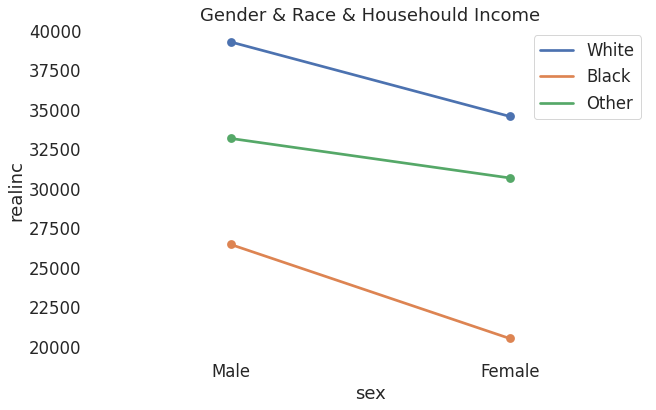

In [ ]:
sns.pointplot(data= gss, x="sex", y="realinc", hue="race", join= True, ci= None)
plt.legend(["White", "Black", "Other"])
plt.title("Gender & Race & Househould Income");

## ***Feature engineering.***
Let's collapse education level into few, for better intution.
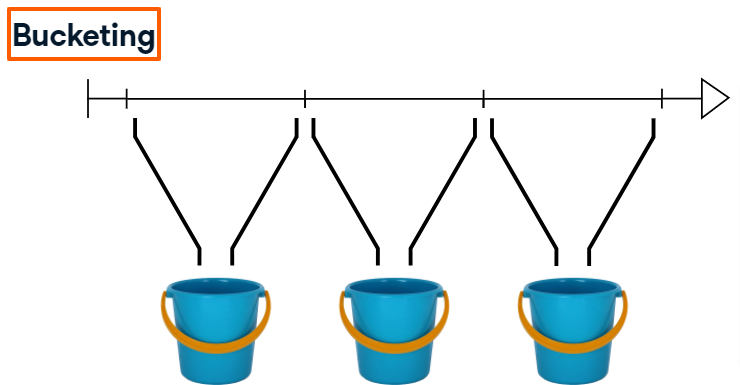

In [ ]:
# Using cut() - create category ranges and names
ranges = [0, 4, 8, 12, 16, np.inf]
group_names = ["0-4", "4-8", "8-12", "12-16", "ad_studies+"]
# Create income group column
gss['edu_level'] = pd.cut(gss['educ'], bins=ranges, labels=group_names)
gss.head()

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall,edu_level
0,1972,26,1946,Male,white,18,13537.0,No,Don't know,0.8893,ad_studies+
1,1972,38,1934,Female,white,12,18951.0,Yes,Don't know,0.4446,8-12
2,1972,57,1915,Male,white,12,30458.0,Yes,Don't know,1.3339,8-12
3,1972,61,1911,Female,white,14,37226.0,Yes,Don't know,0.8893,12-16
4,1972,59,1913,Male,white,12,30458.0,No,Don't know,0.8893,8-12


In [ ]:
Inform(data_frame= gss, groupby=["sex", "race"], column="edu_level")

edu_level                                 
                   0-4    4-8   8-12  12-16 ad_studies+
sex    race                                            
Female Black      1.9%   9.0%  48.6%  35.9%        4.7%
       Other      2.1%  10.0%  36.9%  41.7%        9.3%
       white      0.7%   6.6%  46.9%  36.9%        8.9%
Male   Black      3.7%   8.5%  52.0%  31.2%        4.6%
       Other      3.3%  10.6%  35.6%  38.9%       11.6%
       white      1.0%   6.9%  41.5%  38.6%       12.0%

White people, whether male or female, have obtained higher-education levels at higher rates than the rest, and ***this explains why they get higher salaries***, because previously we found that the higher the number of years of education, the higher the income level.

What about age ?! Does age affect annual income?

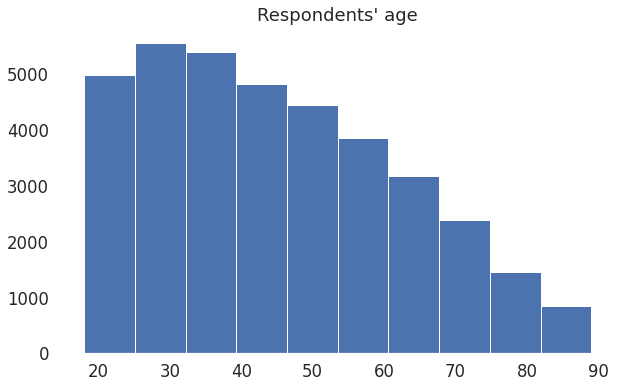

In [ ]:
plt.hist(gss["age"], bins=10)
plt.title("Respondents' age");

Not surprisingly, it's right-skewed distribution.

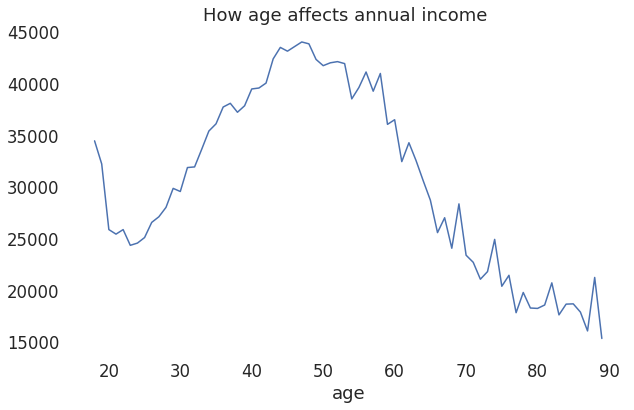

In [ ]:
gss.groupby(by= "age").realinc.mean().plot()
plt.title("How age affects annual income ");

very interesting ! A strong relationship between age and houshould income.





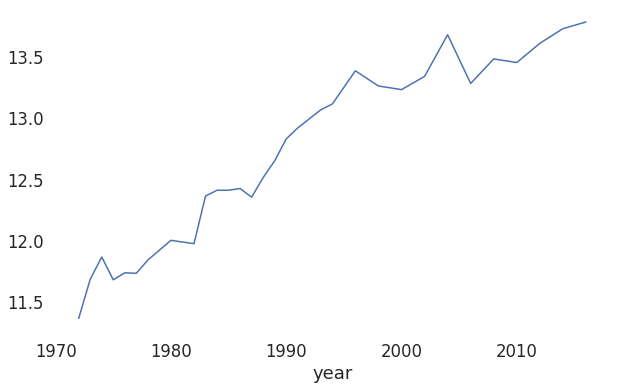

In [ ]:
gss.groupby(by= "year").educ.mean().plot()

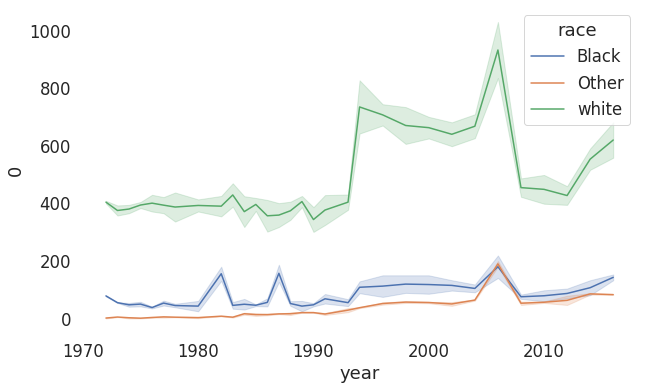

In [ ]:
sex_year= pd.DataFrame(gss.groupby(by= ["year", "sex", "race"]).size()).reset_index()
sns.lineplot(data= sex_year, x="year", y=0, hue="race");

gunlow, Questions associated with this variable:
    
    Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

In [ ]:
Inform(data_frame= gss, groupby=["race", "sex"], column= "gunlaw")

gunlaw              
gunlaw       Missied     No    Yes
race  sex                         
Black Female   34.8%  10.0%  55.2%
      Male     33.3%  15.5%  51.1%
Other Female   43.0%   7.0%  50.0%
      Male     40.3%  11.3%  48.4%
white Female   35.6%  11.9%  52.5%
      Male     33.8%  21.7%  44.6%

***Regardless of race or gender***, ***the majority prefer obtain a police pemit*** before he/ she could obtain a weapon, and after that, comes ***"refusing to answer the question"*** which we recorded as ***missied*** here, and ***small percentage in all fractions answered with “No”***.
<br> For better eyeview, let's visualize it.

In [ ]:
def display_percentage_with_hue_col(data, plot, feature, Number_of_categories, hue_categories, col):
  for graph in plot.axes.ravel():
      category= graph.title.get_text().split()[2]
      a = [p.get_height() for p in graph.patches]
      patch = [p for p in graph.patches]
      for i in range(Number_of_categories):
          slices = data[data[col]== category]
          total= slices[feature].value_counts().values[i]         
          for j in range(hue_categories):
              percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
              x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width()
              y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
              graph.annotate(percentage, (x, y+2), ha="right", size=12, weight= "bold")

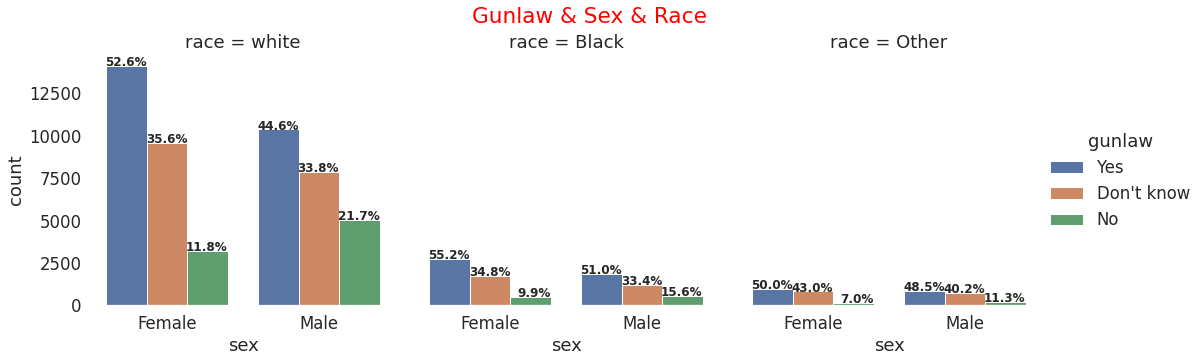

In [ ]:
plot= sns.catplot(data= gss, x="sex", hue="gunlaw", col="race", kind="count", 
                  hue_order= gss.gunlaw.value_counts().index, 
                  col_order= gss.race.value_counts().index,
                  order= gss.sex.value_counts().index)

plt.suptitle("Gunlaw & Sex & Race", y= 1.02, color= "red")

display_percentage_with_hue_col(gss, plot, "sex", 2, 3, "race")

In [ ]:
subset= gss[["sex", "race", "gunlaw"]].dropna()
fig= px.sunburst(subset, path=["race", "sex", "gunlaw"], width=750, height=600, title= "Gender and race and gunlaw")
fig.update_layout(margin=dict(t=100, l=0, r=0, b=0)).update_traces(texttemplate="%{label}<br>%{percentEntry:.2%}")
fig.show()

In [ ]:
import plotly
path= "/content/gdrive/MyDrive/sunbrust.html"
plotly.offline.plot(fig, filename=path)

'/content/gdrive/MyDrive/sunbrust.html'

In [ ]:
pd.DataFrame(gss.groupby(by= "educ").gunlaw.value_counts(normalize=True)* 100).unstack()

gunlaw                      
gunlaw Don't know         No        Yes
educ                                   
0.0     48.905109  10.218978  40.875912
1.0     39.473684  13.157895  47.368421
2.0     33.112583  13.907285  52.980132
3.0     34.285714  10.612245  55.102041
4.0     30.795848  19.723183  49.480969
5.0     27.440633  19.261214  53.298153
6.0     30.760095  17.339667  51.900238
7.0     27.972028  16.783217  55.244755
8.0     28.198758  18.840580  52.960663
9.0     31.820500  18.001020  50.178480
10.0    29.982238  17.335702  52.682060
11.0    32.487047  16.554404  50.958549
12.0    34.564022  16.800209  48.635769
13.0    36.390642  15.131823  48.477534
14.0    38.712459  13.823825  47.463716
15.0    38.113741  15.294949  46.591310
16.0    37.734897  12.927229  49.337874
17.0    34.117647  14.061625  51.820728
18.0    37.792642  10.463450  51.743908
19.0    36.398964  11.917098  51.683938
20.0    35.503876  11.627907  52.868217

grass column:
Questionassiciated with it, is SHOULD MARIJUANA BE MADE LEGAL ?

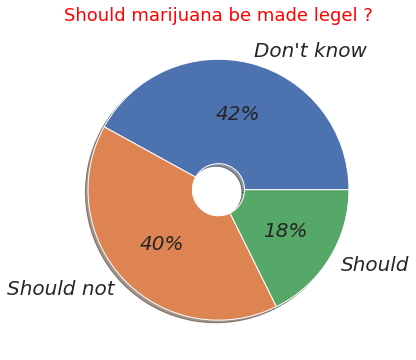

In [ ]:
display_pie(dataframe= gss, column= "grass", title= "Should marijuana be made legel ?")

In [ ]:
#gunlaw_yes_df= gss[gss["gunlaw"]== "Yes"]

#gunlaw_yes= pd.DataFrame(gunlaw_yes_df.groupby(by=["grass", "sex", "race", "edu_level"]).size())
#gunlaw_yes.iloc[gunlaw_yes.index.get_level_values("gunlaw") == "Yes"]
#gunlaw_yes.iloc[:, gunlaw_yes.columns.get_level_values("gunlaw") == "Yes"]
gunlaw_yes

0
grass      sex    race  edu_level        
Don't know Female Black 0-4            24
                        4-8           152
                        8-12          678
                        12-16         491
                        ad_studies+    90
...                                   ...
Should not Male   white 0-4            57
                        4-8           357
                        8-12         1435
                        12-16        1090
                        ad_studies+   355

[90 rows x 1 columns]

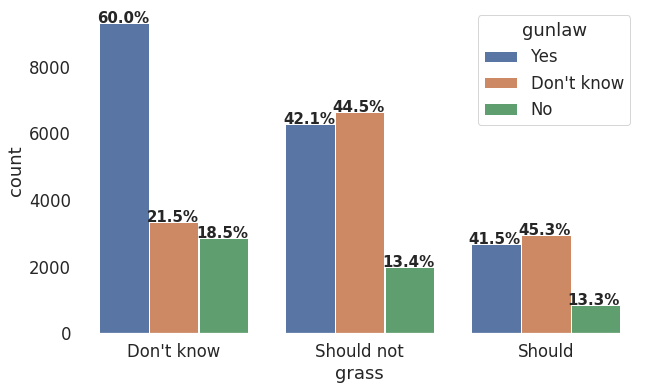

In [24]:
ax= sns.countplot(data= gss, x="grass", hue= "gunlaw", order=gss.grass.value_counts().index, 
                  hue_order=gss.gunlaw.value_counts().index)
display_percentage_with_hue(ax, gss.grass, 3, 3)

## ***Pattern recognition.***

In [ ]:
df= newdata= pd.get_dummies(gss, columns=["sex", "race", "grass"])

In [ ]:
X = df.drop("gunlaw", axis= 1)
Y = df["gunlaw"]

In [ ]:
from sklearn.model_selection import train_test_split # Import train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Extract rules frim descion tree.

In [ ]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
get_rules(clf, df.columns, df["gunlaw"].unique())

['if (sex > 1.5) and (educ <= 15.5) and (grass > 1.833) and (race <= 1.5) and (educ <= 14.5) and (grass <= 2.162) and (grass > 2.032) and (educ > 8.5) and (educ > 11.5) then class: 1.0 (proba: 100.0%) | based on 90 samples',
 'if (sex > 1.5) and (educ <= 15.5) and (grass > 1.833) and (race > 1.5) and (grass > 2.125) and (age > 22.5) then class: 1.0 (proba: 100.0%) | based on 89 samples',
 'if (sex > 1.5) and (educ > 15.5) and (grass <= 2.985) and (race > 1.5) and (age <= 69.5) and (age <= 32.5) then class: 1.0 (proba: 100.0%) | based on 71 samples',
 'if (sex > 1.5) and (educ <= 15.5) and (grass <= 1.833) and (grass > 0.624) and (age <= 54.5) and (educ > 4.5) and (grass > 0.803) and (grass <= 1.375) and (grass > 1.065) and (age > 19.5) and (grass <= 1.137) and (age <= 48.5) and (age <= 43.5) and (age > 31.5) and (grass > 1.092) and (educ <= 13.5) then class: 1.0 (proba: 100.0%) | based on 67 samples',
 'if (sex <= 1.5) and (educ <= 15.5) and (race > 1.5) and (educ > 11.5) and (grass > 

In [ ]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != tree_.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != tree_.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [ ]:
tree_to_code(clf, df.columns)

AttributeError: ignored

In the previous section we plotted mean and standard deviation of polviews over time. Both plots are quite noisy.

We can use local regression to compute a smooth line through these data points.

The following function takes a Pandas Series and uses and algorithm called LOWESS to compute a smooth line. LOWESS stands for “locally weighted scatterplot smoothing”.
https://en.wikipedia.org/wiki/Local_regression


In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 